<a href="https://colab.research.google.com/github/ard8/lifeexp_gdp/blob/main/CS598_CODING3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

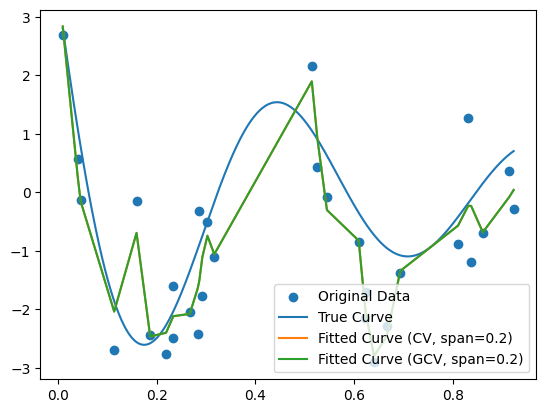

Optimal span based on CV: 0.2
Optimal span based on GCV: 0.2


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skmisc.loess import loess

# Calculate LOO-CV
def calculate_cv(y_fit, y):
    cv = np.mean((y - y_fit) ** 2)
    return cv

# Calculate GCV
def calculate_gcv(y_fit, y, span):
    n = len(y)
    gcv = (1 / n) * np.sum((y - y_fit) ** 2) / (1 - span) ** 2
    return gcv

# Load data
data = pd.read_csv('https://liangfgithub.github.io/Data/Coding3_Data.csv')
x = data['x']
y = data['y']

# variables
span_values = np.arange(0.20, 0.91, 0.05)
cv_values = []
gcv_values = []

# Loop to calculate CV and GCV
for span in span_values:
    loess_model = loess(x, y, span=span)
    loess_model.fit()
    y_fit = loess_model.predict(x).values

    cv = calculate_cv(y_fit, y)
    gcv = calculate_gcv(y_fit, y, span)

    cv_values.append(cv)
    gcv_values.append(gcv)

# Find optimal span values
optimal_span_cv = span_values[np.argmin(cv_values)]
optimal_span_gcv = span_values[np.argmin(gcv_values)]

# Plotting
plt.scatter(x, y, label='Original Data')

# True curve
x_true = np.linspace(min(x), max(x), 500)
y_true = np.sin(12 * (x_true + 0.2)) / (x_true + 0.2)
plt.plot(x_true, y_true, label='True Curve')

# Fitted curve using optimal spans
loess_model_cv = loess(x, y, span=optimal_span_cv)
loess_model_cv.fit()
y_fit_cv = loess_model_cv.predict(x).values

loess_model_gcv = loess(x, y, span=optimal_span_gcv)
loess_model_gcv.fit()
y_fit_gcv = loess_model_gcv.predict(x).values

plt.plot(x, y_fit_cv, label=f'Fitted Curve (CV, span={optimal_span_cv})')
plt.plot(x, y_fit_gcv, label=f'Fitted Curve (GCV, span={optimal_span_gcv})')

plt.legend()
plt.show()

print(f"Optimal span based on CV: {optimal_span_cv}")
print(f"Optimal span based on GCV: {optimal_span_gcv}")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("/Users/antoniorobertodegodoyfilho/Downloads/Sales_Transactions_Dataset_Weekly.csv", index_col=0)

# Slice the data to first 52 columns if needed
X = df.iloc[:, :52].values

# De-mean the data
X_demeaned = X - np.mean(X, axis=1, keepdims=True)

# Function to construct F
def natural_cubic_spline_basis(x, df=10):
    n = len(x)
    k = df - 2  # Number of internal knots
    knots = np.linspace(min(x), max(x), k + 2)[1:-1]

    # Initialize basis matrix
    basis = np.zeros((n, df))

    # First and second column are x and x^2
    basis[:, 0] = x
    basis[:, 1] = x ** 2

    # Remaining columns are truncated power basis functions
    for i, knot in enumerate(knots):
        basis[:, i + 2] = np.maximum((x - knot) ** 3, 0)

    return basis

# Generate a time vector
time_vector = np.linspace(1, 52, 52)

# Generate the basis
F = natural_cubic_spline_basis(time_vector)

# Remove mean from each column to exclude intercept term
F_demeaned = F - np.mean(F, axis=0)

# Calculate B Matrix
F_no_intercept = F_demeaned
print("Shape of F_no_intercept:", F_no_intercept.shape)
print("Shape of X_demeaned:", X_demeaned.shape)

Bt = np.linalg.inv(F_no_intercept.T @ F_no_intercept) @ F_no_intercept.T @ X_demeaned.T
B = Bt.T

# Run K-means Algorithm
kmeans = KMeans(n_clusters=6)
kmeans.fit(B)
labels = kmeans.labels_

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    cluster_idx = np.where(labels == i)[0]
    cluster_data = X_demeaned[cluster_idx, :]

    # Plot all time series in the cluster
    for series in cluster_data:
        ax.plot(series, color='grey', alpha=0.5)

    # Plot the cluster center
    center = kmeans.cluster_centers_[i]
    ax.plot(F_no_intercept @ center, color='red')

plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("/Users/antoniorobertodegodoyfilho/Downloads/Sales_Transactions_Dataset_Weekly.csv", index_col=0)

# Use only the first 52 columns
X = df.iloc[:, :52].values

# De-mean the data
X_demeaned = X - np.mean(X, axis=1, keepdims=True)

# Run K-means Algorithm on X_demeaned
kmeans_X = KMeans(n_clusters=6)
kmeans_X.fit(X_demeaned)
labels_X = kmeans_X.labels_

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    cluster_idx = np.where(labels_X == i)[0]
    cluster_data = X_demeaned[cluster_idx, :]

    # Plot all time series in the cluster
    for series in cluster_data:
        ax.plot(series, color='grey', alpha=0.5)

    # Plot the cluster center
    center_X = kmeans_X.cluster_centers_[i]
    ax.plot(center_X, color='red')

plt.show()

In [20]:
import numpy as np
import pandas as pd

def ridgeless_least_squares(train_data, test_data, eps=1e-10):
    # Separate the response (Y) and features (X) for the training and test data
    Y_train = train_data[:, 0]
    X_train = train_data[:, 1:]

    Y_test = test_data[:, 0]
    X_test = test_data[:, 1:]

    # Perform SVD on the centered training data
    U, S, VT = np.linalg.svd(X_train - np.mean(X_train, axis=0), full_matrices=False)

    # Exclude directions with very small singular values
    valid_indices = np.where(S > eps)[0]
    U = U[:, valid_indices]
    S = S[valid_indices]
    VT = VT[valid_indices, :]

    # Calculate coefficients without need for matrix inversion
    coefficients = VT.T @ np.diag(S ** (-1)) @ U.T @ Y_train

    # Calculate predicted values for training and test set
    Y_train_pred = X_train @ coefficients
    Y_test_pred = X_test @ coefficients

    # Calculate errors (MSE)
    train_error = np.mean((Y_train - Y_train_pred)**2)
    test_error = np.mean((Y_test - Y_test_pred)**2)

    return train_error, test_error

# Load training and test data
train_data = pd.read_csv('https://liangfgithub.github.io/F22/Coding3_dataH.csv').values
test_data = pd.read_csv('https://liangfgithub.github.io/F22/Coding3_dataH.csv').values

# Execute Ridgeless Least Squares and get errors
train_error, test_error = ridgeless_least_squares(train_data, test_data)

print(f"Training error: {train_error}")
print(f"Test error: {test_error}")

Training error: 9.733513427936833
Test error: 9.733513427936833


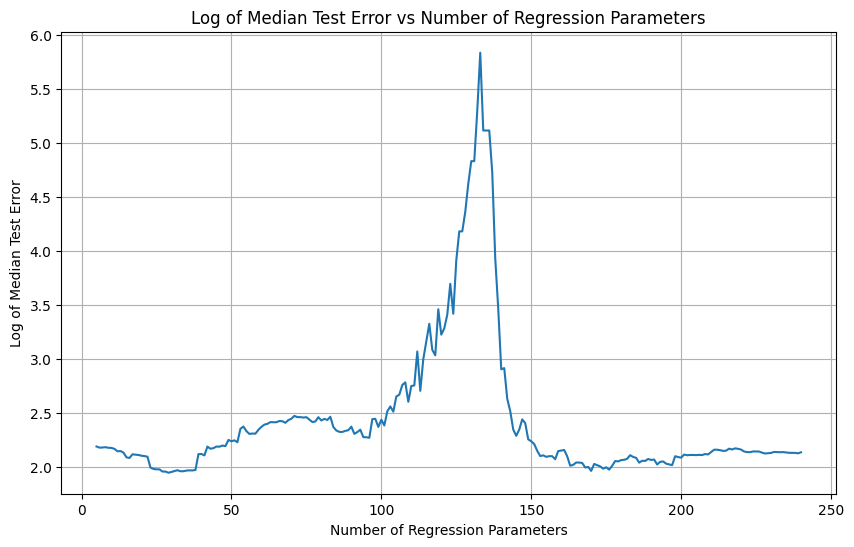

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('https://liangfgithub.github.io/F22/Coding3_dataH.csv').values

# Number of simulations
T = 30

# Initialize matrix to store test errors
test_errors = np.zeros((T, 236))

# Loop through simulations
for t in range(T):
    # Randomly split data into training (25%) and test (75%) sets
    train_data, test_data = train_test_split(data, test_size=0.75, random_state=t)

    # Loop through each d from 6 to 241
    for d in range(6, 242):
        # Subset the data to include only the first d columns (1 column for Y + (d-1) columns for X)
        train_data_sub = train_data[:, :d]
        test_data_sub = test_data[:, :d]

        # Get the test error using ridgeless_least_squares (defined in previous task)
        _, test_error = ridgeless_least_squares(train_data_sub, test_data_sub)

        # Log the test error
        test_errors[t, d-6] = test_error

# Calculate the median of the test errors across the 30 iterations
median_errors = np.median(test_errors, axis=0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(5, 241), np.log(median_errors))
plt.xlabel('Number of Regression Parameters')
plt.ylabel('Log of Median Test Error')
plt.title('Log of Median Test Error vs Number of Regression Parameters')
plt.grid(True)
plt.show()